In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pseudo_arclength import *  # Local file, for multiple solutions

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
from Models import *
from Models.FENE import *

In [3]:
ndim = 3  # Spatial dimensions

## Steady Extension

In [4]:
Wimax = 1e1  # Maximum Weissenberg number

In [5]:
def extensional_flow(b, Wimax, constEq, con_kwargs={}, pal_kwargs={}):
    """Extensional flow for different constitutive models.

    Parameters
    ----------
    b : 0 or 1
        Uniaxial (0) or planar (1) extensional flow.
    Wimax : float
        Maximal Wi-value.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    con_kwargs : dict, optional
        Parameters for constitutive model.
    pal_kwargs : dict, optional
        Parameters for pseudo-arclength continuation.

    Returns
    -------
    Wi : narray
        Array of Weissenberg numbers.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different extensional flows (non-dimensional)
    gradU = np.array([[-0.5*(1+b), 0.0, 0.0],
                      [ 0.0,-0.5*(1-b), 0.0],
                      [ 0.0, 0.0, 1]])
    # Residual + residual for arclength
    residual = lambda A, Wi: constEq.equation(A, gradU, Wi, **con_kwargs)
    adj_residual = lambda T: residual(T[:-1].reshape(constEq.zero_state(ndim).shape), T[-1]).flatten()
    # Run pseudo-arclength continuation
    T0 = np.hstack([constEq.zero_state(ndim).flatten(), 1e-5])
    T = pseudo_arclength(adj_residual, T0, Wimax, **pal_kwargs)
    # Transform output
    nSteps = len(T)
    τ = np.empty((nSteps, ndim, ndim))
    Wi = np.empty((nSteps))
    for idx in range(nSteps):
        A = T[idx][:-1].reshape(constEq.zero_state(ndim).shape)
        Wi[idx] = T[idx][-1]
        τ[idx] = Wi[idx]*constEq.stress_tensor(A, gradU, Wi[idx], **con_kwargs)
    return Wi, τ

In [6]:
models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus
]
model_parameters = [
    {"β":0.0},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.1},
    {"β":0.0, "α":0.2}
]

In [7]:
res = []  # Result of every model requested
for idx, model in enumerate(models):
    Wi_uniaxi, τ_uniaxi = extensional_flow(0, Wimax, model, model_parameters[idx])
    Wi_planar, τ_planar = extensional_flow(1, Wimax, model, model_parameters[idx])
    res.append((Wi_uniaxi, τ_uniaxi, Wi_planar, τ_planar))

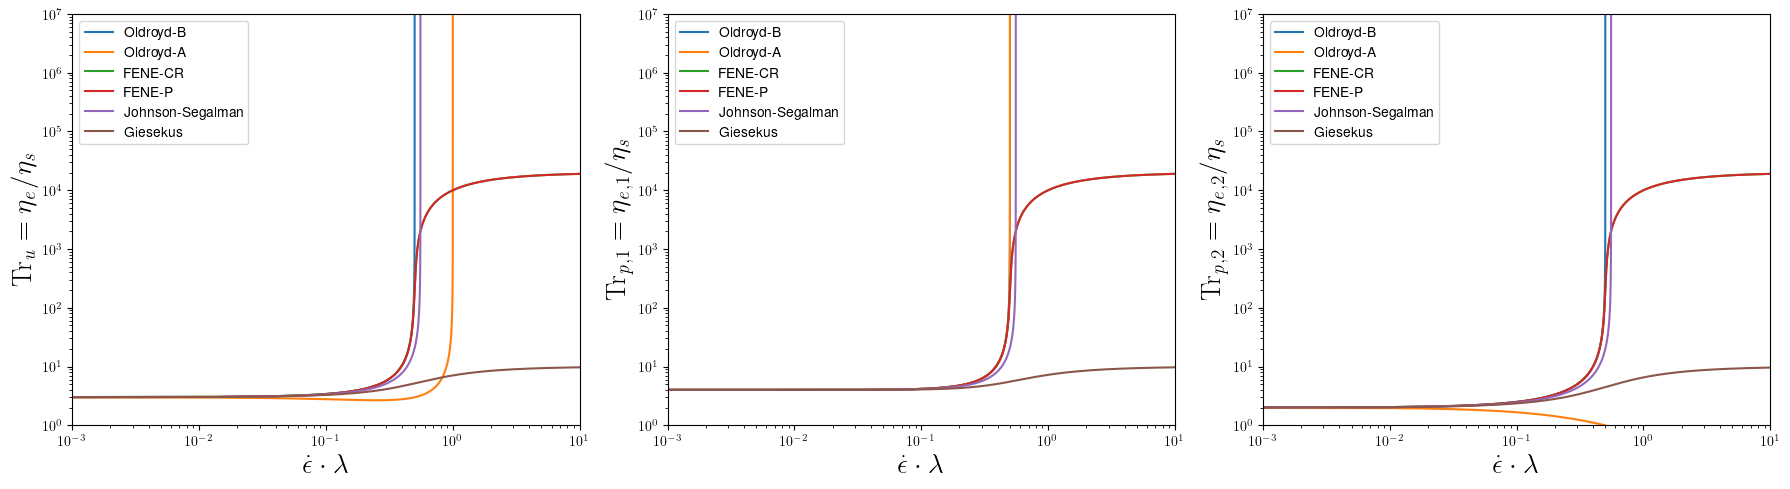

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for idx, model in enumerate(models):
    Wi_uniaxi, τ_uniaxi, Wi_planar, τ_planar = res[idx]
    axes[0].plot(Wi_uniaxi, (τ_uniaxi[:,2,2]-τ_uniaxi[:,0,0])/Wi_uniaxi, label=model.name)
    axes[1].plot(Wi_planar, (τ_planar[:,2,2]-τ_planar[:,0,0])/Wi_planar, label=model.name)
    axes[2].plot(Wi_planar, (τ_planar[:,2,2]-τ_planar[:,1,1])/Wi_planar, label=model.name)

axes[0].set_ylabel("$\\mathrm{Tr}_\\mathit{u} = \\eta_\\mathit{e} / \\eta_\\mathit{s}$", size=20)
axes[1].set_ylabel("$\\mathrm{Tr}_{\\mathit{p},1} = \\eta_{\\mathit{e},1} / \\eta_\\mathit{s}$", size=20)
axes[2].set_ylabel("$\\mathrm{Tr}_{\\mathit{p},2} = \\eta_{\\mathit{e},2} / \\eta_\\mathit{s}$", size=20)
for ax in axes:
    ax.set_xlabel("$\\dot{{\\epsilon}} \\cdot \\lambda$", size=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e-3,Wimax])
    ax.legend()
axes[0].set_ylim([1e0,1e7])
axes[1].set_ylim([1e0,1e7])
axes[2].set_ylim([1e0,1e7])
plt.tight_layout()
plt.show()

## Extension Step

In [9]:
from scipy.integrate import RK45, Radau, LSODA

In [10]:
def extension_startup(b, Wi, constEq, con_kwargs={}, ODESolver=RK45, tmax=1e3, ttol=None, tchange=0.2):
    """Shear flow for different constitutive models.

    Parameters
    ----------
    b : 0 or 1
        Uniaxial (0) or planar (1) extensional flow.
    Wi : float
        Wi-value.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    con_kwargs : dict
        Parameters for constitutive model.
    ODESolver : scipy.integrate.ODESolver
        Solver for the ODE.
    tmax : float
        Maximum time value (early stopping if seemingly converged).
    ttol : float
        Tolerance before assuming steady state is reached.
    tchange : float
        Fraction of total time to switch to extension cessation
        (hard coded 1% of original).

    Returns
    -------
    t : narray
        Array of time steps.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different extensional flows (non-dimensional)
    gradU = np.array([[-0.5*(1+b), 0.0, 0.0],
                      [ 0.0,-0.5*(1-b), 0.0],
                      [ 0.0, 0.0, 1]])
    # Off-On function
    time_control = lambda t: 1.0 if t < tmax * tchange else 0.01
    # Initial values
    t0 = 0.0
    A0 = constEq.zero_state(ndim)
    # RHS
    rhs = lambda A, t: -constEq.equation(A, time_control(t)*gradU, Wi, **con_kwargs)
    adj_rhs = lambda t, A: rhs(A.reshape(A0.shape),t).flatten()
    # Run ODE
    sol = ODESolver(adj_rhs, t0, A0.flatten(), tmax, max_step=1)

    tvals = [t0]
    Avals = [A0]
    running = True
    while running:
        # Solve next step
        sol.step()
        tvals.append(sol.t)
        Avals.append(sol.y.reshape(A0.shape))
        # Determine end criterions:
        if  sol.status == "finished" or  sol.status == "failed":
            warnings.warn(f"Ended due to solver status={sol.status}",
                          RuntimeWarning)
            running = False
        elif ttol is not None and np.linalg.norm(Avals[-1]-Avals[-2]) < np.linalg.norm(Avals[-1])*ttol:
            running = False

    # Transform output
    nSteps = len(tvals)
    τ = np.empty((nSteps, ndim, ndim))
    t = np.array(tvals)
    for idx in range(nSteps):
        A = Avals[idx].reshape(A0.shape)
        τ[idx] = Wi*constEq.stress_tensor(A, gradU, Wi, **con_kwargs)
    return t, τ

In [11]:
Wi_startup = 1.2
models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus,
    FENE_P_Multimode.FENE_P_Multimode(6),
]
model_parameters = [
    {"β":0.0},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.2},
    {"β":0.0, "α":0.9},
    {"β":[0.1, 0.2, 0.3, 0.2, 0.1, 0.1], "L": [100, 80, 60, 40, 20, 10], "λfrac": [1.0, 0.8, 0.6, 0.4, 0.2, 0.1]},
]

In [12]:
res_startup = []  # Result of every model requested
for idx, model in enumerate(models):
    t_uniaxi, τ_uniaxi = extension_startup(0, Wi_startup, model, model_parameters[idx], ODESolver=LSODA, tmax=1e2, tchange=0.2)
    t_planar, τ_planar = extension_startup(0, Wi_startup, model, model_parameters[idx], ODESolver=LSODA, tmax=1e2, tchange=0.2)
    res_startup.append((t_uniaxi, τ_uniaxi, t_planar, τ_planar))

/var/folders/c5/lbbmdc4d2vg95yy7720wmcyh0000gp/T/ipykernel_20204/2586611821.py:56: RuntimeWarning: Ended due to solver status=finished
  warnings.warn(f"Ended due to solver status={sol.status}",


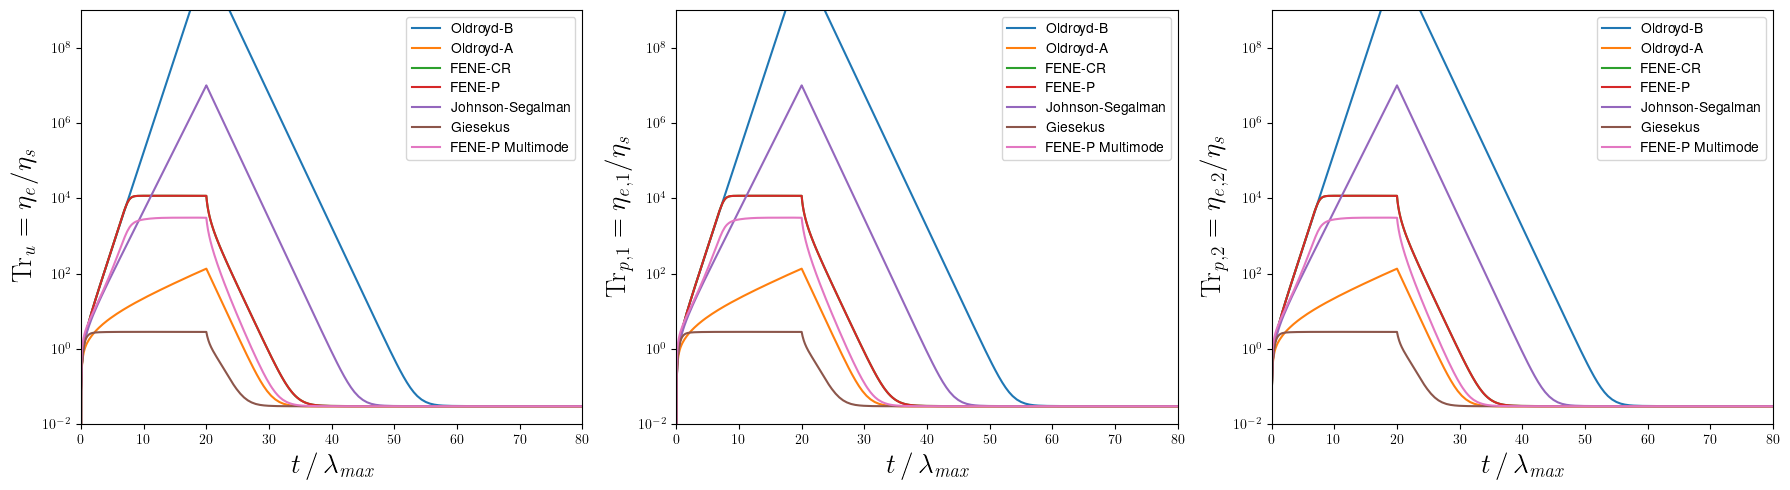

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for idx, model in enumerate(models):
    t_uniaxi, τ_uniaxi, t_planar, τ_planar = res_startup[idx]
    axes[0].plot(t_uniaxi, (τ_uniaxi[:,2,2]-τ_uniaxi[:,0,0])/Wi_startup, label=model.name)
    axes[1].plot(t_planar, (τ_planar[:,2,2]-τ_planar[:,0,0])/Wi_startup, label=model.name)
    axes[2].plot(t_planar, (τ_planar[:,2,2]-τ_planar[:,1,1])/Wi_startup, label=model.name)

axes[0].set_ylabel("$\\mathrm{Tr}_\\mathit{u} = \\eta_\\mathit{e} / \\eta_\\mathit{s}$", size=20)
axes[1].set_ylabel("$\\mathrm{Tr}_{\\mathit{p},1} = \\eta_{\\mathit{e},1} / \\eta_\\mathit{s}$", size=20)
axes[2].set_ylabel("$\\mathrm{Tr}_{\\mathit{p},2} = \\eta_{\\mathit{e},2} / \\eta_\\mathit{s}$", size=20)
for ax in axes:
    ax.set_xlabel("$t \\,/\\, \\lambda_\\mathit{max}$", size=20)
    ax.set_yscale("log")
    ax.set_xlim([0,80])
    ax.legend()
axes[0].set_ylim([1e-2,1e9])
axes[1].set_ylim([1e-2,1e9])
axes[2].set_ylim([1e-2,1e9])
plt.tight_layout()
plt.show()